In [122]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import tempfile
from tabulate import tabulate
import torch

# Transfer Learning

# Initial Data Loading and Processing

In the next rows, we will declare some functions to will help us with the transfer learning process. 
Specifically, we will need to:
1. download the CIFAR-10 dataset.
2. Get the device to run the model on (Help us to make the code device agnostic)
3. Visualize images from the dataset













In [123]:
# Download CIFAR-10 dataset and create data loaders
def get_cifar10_loaders(num_train=45000, batch_size=64, data_path=None):
    """
    Creates and returns DataLoaders for CIFAR-10 dataset with proper transformations
    for transfer learning.

    Args:
        num_train (int): Number of training samples (default: 45000)
        batch_size (int): Size of mini-batches (default: 64)
        data_path (str): Path to store/load dataset. If None, uses temp directory

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Use temporary directory if no path specified
    if data_path is None:
        import tempfile
        data_path = tempfile.gettempdir()

    # Define transformations for transfer learning with ImageNet models
    transform_imagenet = T.Compose([
        T.Resize(224),                # Resize images to ImageNet size
        T.ToTensor(),                 # Convert to tensor (0-1 range)
        # ImageNet normalization values
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load training dataset and create train/val split
    cifar10_train = datasets.CIFAR10(data_path,
                                    train=True,
                                    download=True,
                                    transform=transform_imagenet)

    # Create training loader with subset sampler
    train_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train))
    )

    # Create validation loader with remaining training data
    val_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train, len(cifar10_train)))
    )

    # Load and create test loader
    cifar10_test = datasets.CIFAR10(data_path,
                                   train=False,
                                   download=True,
                                   transform=transform_imagenet)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# 2. Get the device to run the model on (Help us to make the code device agnostic)
def get_device(force_cpu=False):
    """
    Returns the best available device for PyTorch operations.

    Args:
        force_cpu (bool): If True, will return CPU even if CUDA is available
                         Useful for debugging or when GPU memory is limited

    Returns:
        torch.device: 'cuda' if GPU is available (and force_cpu=False), 'cpu' otherwise

    Example:
        >>> device = get_device()
        >>> model = model.to(device)
        >>> tensor = tensor.to(device)
    """
    if not force_cpu and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using CUDA device: {torch.cuda.get_device_name(0)}')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    return device

# 3. Visualize images from the dataset
def plot_random_sample(loader, classes=None):
    """
    Randomly selects and plots an image from a DataLoader with its corresponding label.

    Args:
        loader (DataLoader): PyTorch DataLoader containing the dataset
        classes (list, optional): List of class names. If None, will only show class index

    Returns:
        tuple: (image_tensor, label) of the plotted sample

    Example:
        >>> classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
        >>> plot_random_sample(test_loader, classes)
    """
    # Get a random index
    rnd_sample_idx = np.random.randint(len(loader.dataset))

    # Get the image and label
    image, label = loader.dataset[rnd_sample_idx]

    # Normalize image for visualization
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Print the class
    if classes:
        print(f'This image represents: {classes[label]}')
    else:
        print(f'Class index: {label}')

    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_normalized.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    return image, label

Files already downloaded and verified
Files already downloaded and verified
Using CPU

Viewing random samples from training data:
This image represents: Car


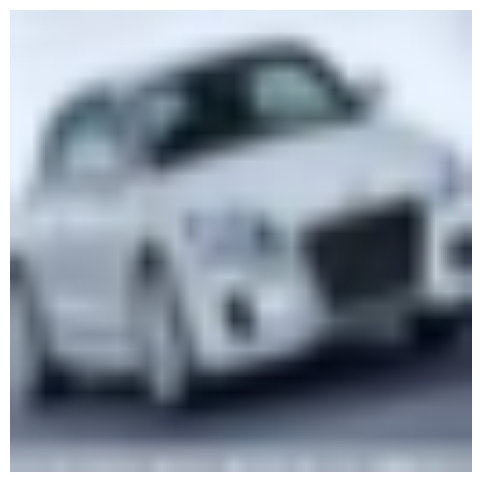

In [124]:
# Get the data ready
train_loader, val_loader, test_loader = get_cifar10_loaders()
device = get_device()

# Define CIFAR-10 classes for better visualization
cifar10_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Visualize some random samples from training data
print("\nViewing random samples from training data:")
for _ in range(1):  # Show 3 random samples
    plot_random_sample(train_loader, cifar10_classes)

## Downloads the Models

1. Download pretrained models from PyTorch Hub 
2. Explore the model architecture


In [125]:
def get_pretrained_model(model_name='resnet18'):
    """
    Get a pretrained model from PyTorch's model zoo without modifying its architecture.

    Args:
        model_name (str): Name of the pretrained model to load
            Options: 'resnet18', 'alexnet', 'vgg16', 'densenet121'

    Returns:
        model: Original pretrained PyTorch model (1000 ImageNet classes)

    Raises:
        ValueError: If model_name is not supported
    """
    # Dictionary of supported models and their constructors
    models_dict = {
        'resnet18': models.resnet18,
        'alexnet': models.alexnet,
        'vgg16': models.vgg16,
        'densenet121': models.densenet121
    }

    # Check if requested model is supported
    if model_name not in models_dict:
        raise ValueError(f"Model {model_name} not supported. Choose from: {list(models_dict.keys())}")

    # Load pretrained model
    print(f"Loading pretrained {model_name}...")
    model = models_dict[model_name](pretrained=True)

    return model

In [126]:
def model_to_table_summary(model):
    """
    Creates a minimal table showing only the last layer of the model.
    
    Args:
        model (nn.Module): PyTorch model to convert
        
    Returns:
        str: Formatted table showing last layer
    """
    table_data = []
    
    def get_last_layer(model):
        """Helper function to get the last linear layer based on model architecture"""
        if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):  # DenseNet
            return model.classifier
        elif hasattr(model, 'classifier'):  # AlexNet, VGG
            return model.classifier[-1]
        elif hasattr(model, 'fc'):        # ResNet
            return model.fc
        raise ValueError("Could not find last layer")
    
    # Get last layer
    try:
        last_layer = get_last_layer(model)
        table_data.append([
            last_layer.__class__.__name__,
            f"{last_layer.in_features} → {last_layer.out_features}"
        ])
    except Exception as e:
        print(f"Warning: Could not process last layer: {e}")

    headers = ["Type", "Features (in → out)"]
    return tabulate(table_data, headers=headers, tablefmt="grid")



In [127]:
# download the pretrained models
resnet_model = get_pretrained_model(model_name="resnet18")
alexnet_model = get_pretrained_model(model_name="alexnet")
densenet_model = get_pretrained_model(model_name="densenet121")


Loading pretrained resnet18...
Loading pretrained alexnet...


/Users/ness/anaconda3/envs/aurora/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ness/anaconda3/envs/aurora/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ness/anaconda3/envs/aurora/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also us

Loading pretrained densenet121...


/Users/ness/anaconda3/envs/aurora/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [128]:
print(f"ResNet18:\n{model_to_table_summary(resnet_model)}")
print(f"\nAlexNet:\n{model_to_table_summary(alexnet_model)}")
print(f"\nDenseNet:\n{model_to_table_summary(densenet_model)}")


ResNet18:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 512 → 1000            |
+--------+-----------------------+

AlexNet:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 4096 → 1000           |
+--------+-----------------------+

DenseNet:
+--------+-----------------------+
| Type   | Features (in → out)   |
+========+=======================+
| Linear | 1024 → 1000           |
+--------+-----------------------+


In [129]:
def model_to_sequential(model):
    """
    Converts a model to a Sequential container, excluding the last layer.
    
    Args:
        model (nn.Module): Input model (ResNet, AlexNet, DenseNet, etc.)
        
    Returns:
        nn.Sequential: Sequential container with all layers except the last one
    """
    # Get all layers except the last one
    layers = list(model.children())[:-1]
    
    # Create a Sequential container with these layers
    sequential = nn.Sequential(*layers) 
    return sequential

def freeze_parameters(model):
    """
    Freezes all parameters in a model by setting requires_grad=False.
    
    Args:
        model (nn.Module): PyTorch model whose parameters should be frozen
        
    Returns:
        nn.Module: Model with frozen parameters
    """
    for param in model.parameters():
        param.requires_grad = False
    
    return model

def unfreeze_parameters(model):
    """
    Unfreezes all parameters in a model by setting requires_grad=True.
    
    Args:
        model (nn.Module): PyTorch model whose parameters should be unfrozen
        
    Returns:
        nn.Module: Model with unfrozen parameters
    """
    for param in model.parameters():
        param.requires_grad = True
    
    return model

def create_classifier(base_model, model_type, num_classes=10):
    """
    Creates a classifier by adding Flatten and Linear layers to a base model.
    
    Args:
        base_model (nn.Module): Base model without final classification layer
        model_type (str): Type of the original model ('ResNet', 'AlexNet', or 'DenseNet')
        num_classes (int): Number of output classes (default: 10 for CIFAR-10)
        
    Returns:
        nn.Sequential: New model with Flatten and appropriate Linear layer
    """
    # Dictionary mapping model types to their feature dimensions
    feature_dimensions = {
        'ResNet': 512,
        'AlexNet': 9216,
        'DenseNet': 50176
    }
    
    # Get input features based on model type
    for name, dim in feature_dimensions.items():
        if name in model_type:
            in_features = dim
            break
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Create new Sequential model with Flatten and Linear layers
    classifier = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
    )
    
    return classifier



# Traning and accuracy


In [130]:
def accuracy(model, loader):
    """
    Calculate the accuracy of a model on a given dataset.

    Args:
        model: PyTorch model to evaluate
        loader: DataLoader containing the dataset

    Returns:
        float: Accuracy score between 0 and 1
    """
    # Initialize counters for correct predictions and total samples
    num_correct = 0
    num_total = 0

    # Set model to evaluation mode (disables dropout, batch norm adjustments, etc.)
    model.eval()
    # Ensure model is on the correct device
    model = model.to(device=device)

    # Disable gradient calculations for efficiency during evaluation
    with torch.no_grad():
        # Iterate through batches in the data loader
        for (xi, yi) in loader:
            # Move input data to the same device as model
            xi = xi.to(device=device, dtype=torch.float32)  # Move images
            yi = yi.to(device=device, dtype=torch.long)     # Move labels

            # Forward pass: get model predictions
            scores = model(xi)  # Shape: [batch_size, num_classes]

            # Get the predicted class (highest score) for each sample
            _, pred = scores.max(dim=1)  # Shape: [batch_size]

            # Count correct predictions
            num_correct += (pred == yi).sum()  # Compare predictions with true labels

            # Update total number of samples processed
            num_total += pred.size(0)  # Add batch size

        # Calculate and return accuracy as a percentage
        return float(num_correct) / num_total
    
def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model using the specified optimizer.

    Args:
        model: PyTorch model to train
        optimiser: PyTorch optimizer for updating model parameters
        epochs (int): Number of training epochs (default: 100)

    Note:
        - Uses global train_loader for training data
        - Uses global val_loader for validation
        - Uses global device for GPU/CPU placement
    """
    # Move model to appropriate device (GPU/CPU)
    model = model.to(device=device)

    # Training loop over epochs
    for epoch in range(epochs):
        # Inner loop over batches in training data
        for i, (xi, yi) in enumerate(train_loader):
            # Set model to training mode (enables dropout, batch norm, etc.)
            model.train()

            # Move batch data to appropriate device
            xi = xi.to(device=device, dtype=torch.float32)  # Input images
            yi = yi.to(device=device, dtype=torch.long)     # Labels

            # Forward pass: compute predictions
            scores = model(xi)

            # Compute loss
            cost = F.cross_entropy(input=scores, target=yi)

            # Backward pass and optimization
            optimiser.zero_grad()           # Clear previous gradients
            cost.backward()                 # Compute gradients
            optimiser.step()                # Update weights

        # Compute validation accuracy after each epoch
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')


# Transfer learning
let's perform transfer learning
```
resnet_model = get_pretrained_model(model_name="resnet18")
alexnet_model = get_pretrained_model(model_name="alexnet")
densenet_model = get_pretrained_model(model_name="densenet121")
```

## Alexnet

In [131]:
# 1. Create a sequential model and remove the last layer 
alexnet_model_aux = model_to_sequential(alexnet_model)
# 2. Freeze all the parameters
alexnet_model_aux = freeze_parameters(alexnet_model_aux)
# 3. Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
alexnet_model_aux = create_classifier(
    base_model=alexnet_model_aux,
    model_type='AlexNet'  # Specify the original model type
)
# Move model to appropriate device
alexnet_model_aux = alexnet_model_aux.to(device)
# Higher learning rate since we're only training the classifier
initial_lr = 5e-4
optimizer = torch.optim.Adam(       
    alexnet_model_aux.parameters(),
    lr=initial_lr
)


In [132]:

alexnet_model_aux

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=9216, out_features=10

In [ ]:
# Train only the classifier (with frozen features)
print("Training AlexNet with frozen features...")
train(alexnet_model_aux, optimizer, epochs=5)  

In [ ]:
# 4. Unfreeze the model for fine-tuning
unfreeze_parameters(alexnet_model_aux)
# 5. Continue training with lower learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
optimizer = torch.optim.Adam(alexnet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning AlexNet...")
train(alexnet_model_aux, optimizer, epochs=3)  # Few epochs of fine-tuning

In [ ]:
# 6. Evaluate final model
final_accuracy = accuracy(alexnet_model_aux, test_loader)
print(f"AlexNet Final test accuracy: {final_accuracy:.4f}")

# densenet

In [133]:
# 1. Create a sequential model and remove the last layer 
densenet_model_aux = model_to_sequential(densenet_model)

# 2. Freeze all the parameters
densenet_model_aux = freeze_parameters(densenet_model_aux)

# 3. Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
densenet_model_aux = create_classifier(
    base_model=densenet_model_aux,
    model_type='DenseNet'  # Specify the original model type
)

# Move model to appropriate device
densenet_model_aux = densenet_model_aux.to(device)

# Higher learning rate since we're only training the classifier
initial_lr = 5e-4
optimizer = torch.optim.Adam(       
    densenet_model_aux.parameters(),
    lr=initial_lr
)

In [134]:
densenet_model_aux

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

In [135]:
# Train only the classifier (with frozen features)
print("Training DenseNet with frozen features...")
train(densenet_model_aux, optimizer, epochs=5)  # Fewer epochs for initial training

In [ ]:
# 4. Unfreeze the model for fine-tuning
unfreeze_parameters(densenet_model_aux)
# 5. Continue training with lower learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
optimizer = torch.optim.Adam(densenet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning DenseNet...")
train(densenet_model_aux, optimizer, epochs=3)  # Few epochs of fine-tuning

In [ ]:
# 6. Evaluate final model
final_accuracy = accuracy(densenet_model_aux, test_loader)
print(f"DenseNet final test accuracy: {final_accuracy:.4f}")

# Resnet

In [136]:
# 1. Create a sequential model and remove the last layer 
resnet_model_aux = model_to_sequential(resnet_model)

# 2. Freeze all the parameters
resnet_model_aux = freeze_parameters(resnet_model_aux)

# 3. Connect a linear layer to create a classifier with 10 classes (matching our CIFAR10)
resnet_model_aux = create_classifier(
    base_model=resnet_model_aux,
    model_type='ResNet'  # Specify the original model type
)

# Move model to appropriate device
resnet_model_aux = resnet_model_aux.to(device)

# Higher learning rate since we're only training the classifier
initial_lr = 5e-4
optimizer = torch.optim.Adam(       
    [param for param in resnet_model_aux.parameters() if param.requires_grad],
    lr=initial_lr
)


In [137]:
resnet_model_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Train only the classifier (with frozen features)
print("Training ResNet with frozen features...")
train(resnet_model_aux, optimizer, epochs=5)  # Fewer epochs for initial training

In [ ]:
# Unfreeze the model for fine-tuning
unfreeze_parameters(resnet_model_aux)
# Continue training with lower learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
optimizer = torch.optim.Adam(resnet_model_aux.parameters(), lr=fine_tune_lr)

print("Fine-tuning ResNet model...")
train(resnet_model_aux, optimizer, epochs=3)  # Few epochs of fine-tuning

In [ ]:
# Evaluate final model
final_accuracy = accuracy(resnet_model_aux, test_loader)
print(f"ResNet final test accuracy: {final_accuracy:.4f}")